# Gnomix Demo


### Loading packages

In [27]:
import numpy as np
import os
import subprocess
import sys
import pandas as pd

#importing module (only for jupytercluster)
exec(open("/shared/software/modules/4.6.1/init/python.py").read(), globals())
module("load", "bcftools")

python='/shared/projects/machinelearning_popgen/conda/envs/TER/bin/python3'
print("bcftools has been loaded")

bcftools has been loaded


In [28]:
# Arguments
data_path="../data/input/real/"
query_file = data_path+ "5pop_285query.vcf.gz"
genetic_map_file = data_path+ "allchrs_b37.gmap"
reference_file   = data_path + "5pop_1425sample.vcf.gz"
sample_map_file  = data_path + "5pop_1425sample.smap"
chm              = "1"
phase            = "False"
output_basename  = "../data/output_gnomix/1425samples_285query/"
if (os.path.isdir(output_basename)==False):
    os.mkdir(output_basename)
    print('Creating directory')

## Training and inference



In [ ]:
train_cmd = " ".join([python,"./gnomix.py",
                      query_file, output_basename,chm, phase, genetic_map_file, reference_file, sample_map_file]) + \
            f" > {output_basename}training_log.txt"
print("Running in command line: \n\t",train_cmd)
os.system(train_cmd)

Running in command line: 
	 /shared/projects/machinelearning_popgen/conda/envs/TER/bin/python3 ./gnomix.py ../data/input/real/5pop_285query.vcf.gz ../data/output_gnomix/1425samples_285query/ 1 False ../data/input/real/allchrs_b37.gmap ../data/input/real/5pop_1425sample.vcf.gz ../data/input/real/5pop_1425sample.smap > ../data/output_gnomix/1425samples_285query/training_log.txt


  3%|█▏                                      | 42/1424 [00:19<03:53,  5.93it/s] 

## Analyzing results

### Reading from the ouput

Here we read the results from the output file into a dataframe

In [15]:
# read the output file into a dataframe
output_file = output_basename+"/query_results.msp"
msp_df = pd.read_csv(output_file, sep="\t", skiprows=[0])
msp_df

,#chm,spos,epos,sgpos,egpos,n snps,NA19834.0,NA19834.1,NA20278.0,NA20278.1,...,HG02278.0,HG02278.1,HG01060.0,HG01060.1,HG01082.0,HG01082.1,HG01272.0,HG01272.1,HG01933.0,HG01933.1
0,1,534247,836924,1.37632,2.23048,46,2,2,4,2,...,4,1,4,1,2,4,4,1,1,2
1,1,837014,869071,2.23086,2.34281,46,2,2,1,2,...,4,1,4,1,2,4,4,1,1,2
2,1,870754,903321,2.34818,2.44537,46,2,2,4,2,...,4,1,4,1,2,4,4,1,1,2
3,1,903426,932457,2.44566,2.52542,46,2,2,4,2,...,4,1,4,1,2,4,4,1,1,2
4,1,934345,974494,2.53061,2.60579,46,2,2,4,2,...,4,1,4,1,2,4,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,1,81579180,81618807,109.22719,109.24459,46,2,3,2,4,...,1,1,4,1,4,1,4,1,1,2
1420,1,81619659,81659678,109.24487,109.28590,46,2,3,2,4,...,1,1,4,1,4,1,4,1,1,2
1421,1,81661320,81702178,109.28617,109.31912,46,2,3,2,1,...,1,1,4,1,4,1,4,1,1,2
1422,1,81702435,81746238,109.31919,109.33146,46,2,1,2,4,...,1,1,4,1,4,1,4,1,1,2


## Measuring performance

In [16]:
from scipy import stats
from sklearn.metrics import confusion_matrix

from src.postprocess import get_samples_from_msp_df
from src.visualization import plot_cm, plot_chm, visualize_palette

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we predict **single ancestry** for each individual by creatoing a dataframe containing only one label prediction for each individual. We do so simply by taking the mode of the local predictions for each individual. 

In [17]:
# reading the sample-ids
query_samples = get_samples_from_msp_df(msp_df)

# reading predictions for each of the intervals
pred_labels = (np.array(msp_df)[:,6:].T).astype(int)

# reducing it to only 1 of maternal/paternal prediction
single_ind_idx = np.arange(0,len(query_samples)*2,2)
pred_labels_single_ind = pred_labels[single_ind_idx,:]

# predicting single ancestry by taking mode of local predictions for each individual
y_pred = stats.mode(pred_labels_single_ind,axis=1)[0].squeeze() 

# get model population order from first line of file and convert from numeric predictions
with open(output_file, "r") as f:
    pop = np.array([p.split("=")[0] for p in f.readline().split()[2:]])
pred_pop = [pop[pop_ind] for pop_ind in y_pred]
print(pop)

# put it together in dataframe
pred_df = pd.DataFrame({"Sample": query_samples, "Prediction": pred_pop})
pred_df

['EAS' 'AMR' 'AFR' 'SAS' 'EUR']


,Sample,Prediction
0,NA19834,AFR
1,NA20278,EUR
2,NA19030,AFR
3,HG03470,AFR
4,HG02878,AFR
...,...,...
280,HG02278,AMR
281,HG01060,EUR
282,HG01082,EUR
283,HG01272,EUR


We can read the true labels from the sample map file and add them to the dataframe. The true ancestry labels (not only single ancestry individuals) are stored in the meta data file *demo/data/1000g.meta*.

In [18]:
# adding the true labels
all_sample_map_file=data_path + 'all_sample.smap'
all_sample_map_df = pd.read_csv(all_sample_map_file, sep="\t",skiprows=[0])
all_sample_map_df.columns = ['Sample', 'Superpopulation code']
true_labels_df = all_sample_map_df[["Sample", "Superpopulation code"]]
true_labels_df.columns = ["Sample", "Population"]
pred_df = pred_df.merge(true_labels_df)
print(pred_df)

      Sample Prediction Population
0    NA19834        AFR        AFR
1    NA20278        EUR        AFR
2    NA19030        AFR        AFR
3    HG03470        AFR        AFR
4    HG02878        AFR        AFR
..       ...        ...        ...
279  HG02278        AMR        AMR
280  HG01060        EUR        AMR
281  HG01082        EUR        AMR
282  HG01272        EUR        AMR
283  HG01933        AMR        AMR

[284 rows x 3 columns]


And then compare the predictions with the true labels

In [19]:
# Getting the prediction accuracy
acc = np.mean(pred_df.Population == pred_df.Prediction)
print("Accuracy for single ancestry: ", acc*100, "%", sep="")

Accuracy for single ancestry: 90.14084507042254%


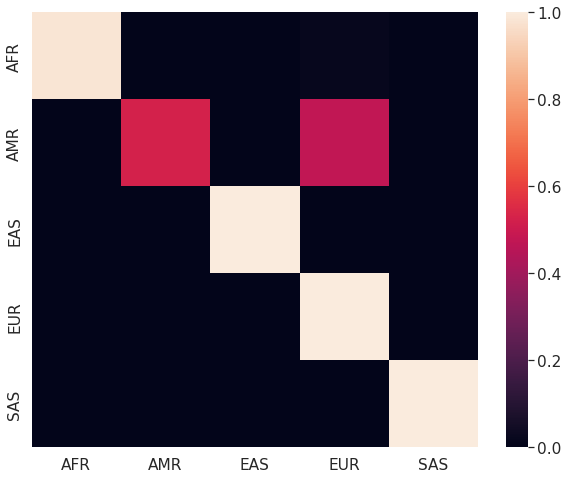

In [20]:
# creating and visualizing the confusion matrix
labs = np.unique(pred_df[['Population', 'Prediction']])
cm = confusion_matrix(pred_df.Population, pred_df.Prediction, labels=labs)
cm_plot = plot_cm(cm, normalize=True, labels=labs)
cm_plot.figure.savefig(f'{output_basename}single_ancestry_confusion_matrix.png')

## Plotting the prediction


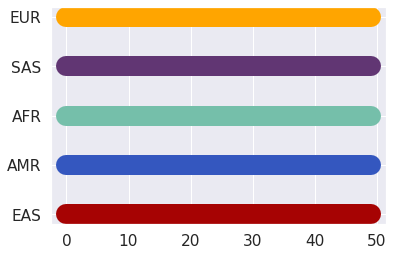

tagore --i ../data/output_gnomix/1425samples_285query/tagore.tsv -p ../data/output_gnomix/1425samples_285query/NA20278_chm_img --build hg37 -f


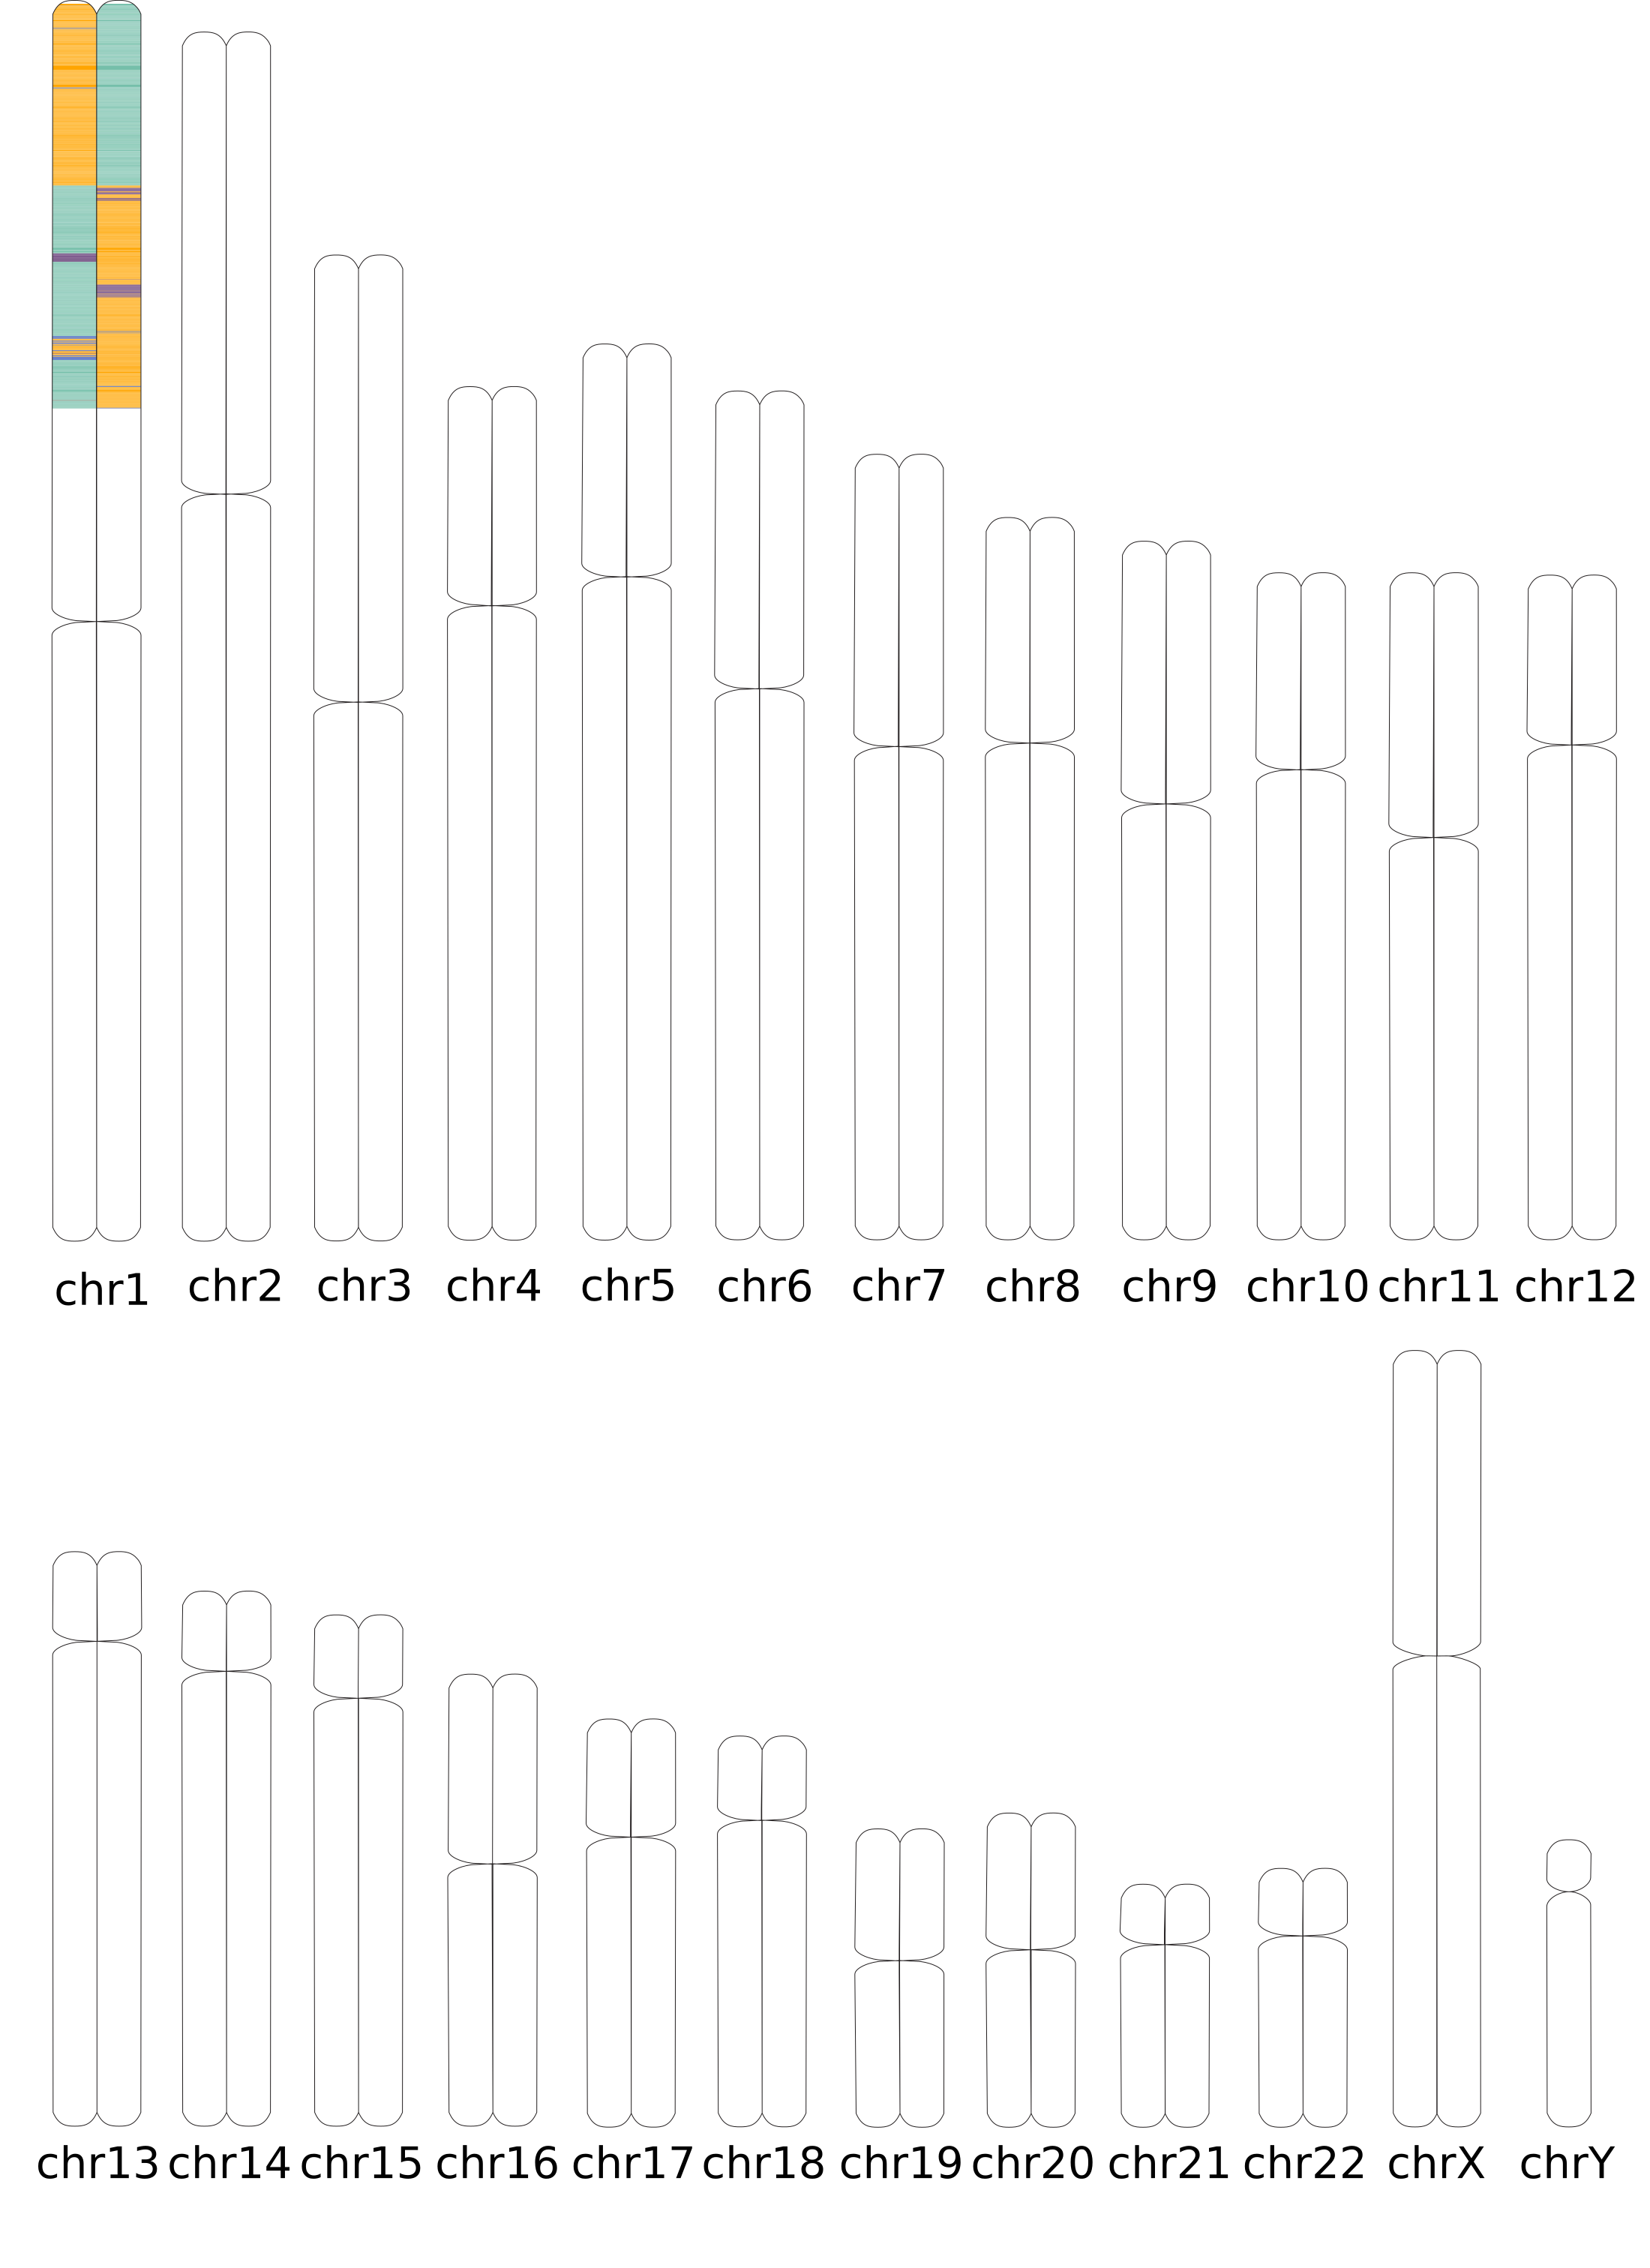

In [26]:
from IPython.display import Image
from src.visualization import plot_cm, plot_chm, visualize_palette

sample_id = "NA20278" # looking at just one random sample
img_name = f"{output_basename}{sample_id}_chm_img"
plot_chm(sample_id, msp_df,output_basename,output_file, img_name=img_name)
Image(filename=img_name+".png",retina=True)